# Finetune ResNet50


With 1000 x 400 melspectrogram images with online data augmentation (Gaussian noise)


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_augmented'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation


In [14]:
from data_augmentation.AddGaussianNoise import AddGaussianNoise

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoise(mean=0.0, std_range=(0.0, 0.1)
                     ),  # Online noise augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define test transformations for both validation and test sets
test_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=1.5405305624008179, Elapsed=20.4664s, ETA=0.0000s] 


Epoch 1 completed in 73.9215s
Train Loss: 1.5188823511145708 - Train Accuracy: 40.41518735442437
Validation Loss: 1.4175609079996745 - Validation Accuracy: 43.58379062895737

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.76it/s, Loss=1.8460954427719116, Elapsed=20.4423s, ETA=0.0000s] 


Epoch 2 completed in 72.9844s
Train Loss: 1.3726756810452896 - Train Accuracy: 45.76784785509147
Validation Loss: 1.457485915819804 - Validation Accuracy: 42.1169269734065

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.92it/s, Loss=1.398407220840454, Elapsed=20.2808s, ETA=0.0000s]  


Epoch 3 completed in 72.6760s
Train Loss: 1.335171823212177 - Train Accuracy: 47.5678976052102
Validation Loss: 1.3853952423731486 - Validation Accuracy: 46.834107218235545

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.89it/s, Loss=1.5103979110717773, Elapsed=20.4680s, ETA=0.0000s] 


Epoch 4 completed in 73.0601s
Train Loss: 1.3078937358249818 - Train Accuracy: 48.94959408425861
Validation Loss: 1.3442367251714071 - Validation Accuracy: 46.98184888138455

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.3739988803863525, Elapsed=20.5141s, ETA=0.0000s] 


Epoch 5 completed in 73.2927s
Train Loss: 1.2973081076765336 - Train Accuracy: 48.9292417629633
Validation Loss: 1.3408596086502076 - Validation Accuracy: 47.308991135500214

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=1.3865047693252563, Elapsed=20.5421s, ETA=0.0000s] 


Epoch 6 completed in 73.0156s
Train Loss: 1.2864949710107263 - Train Accuracy: 49.32724271273829
Validation Loss: 1.3206170463562013 - Validation Accuracy: 48.723089911355

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.81it/s, Loss=1.1688312292099, Elapsed=20.4768s, ETA=0.0000s]    


Epoch 7 completed in 73.0153s
Train Loss: 1.2786624834716664 - Train Accuracy: 50.107415029058586
Validation Loss: 1.4119179662068684 - Validation Accuracy: 45.66272688898269

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.84it/s, Loss=1.0205756425857544, Elapsed=20.3726s, ETA=0.0000s] 


Epoch 8 completed in 72.7724s
Train Loss: 1.2698524091285088 - Train Accuracy: 50.42852943171796
Validation Loss: 1.3200607856114706 - Validation Accuracy: 48.92359645420009

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s, Loss=1.0887049436569214, Elapsed=20.6211s, ETA=0.0000s] 


Epoch 9 completed in 73.1324s
Train Loss: 1.2651809788163686 - Train Accuracy: 50.44435901494765
Validation Loss: 1.3235148080190022 - Validation Accuracy: 49.12410299704516

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.83it/s, Loss=1.3379950523376465, Elapsed=20.5306s, ETA=0.0000s] 


Epoch 10 completed in 73.0133s
Train Loss: 1.2593007745770362 - Train Accuracy: 51.04814454670857
Validation Loss: 1.3888961219787597 - Validation Accuracy: 46.00042211903757

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, Loss=0.894149124622345, Elapsed=20.5662s, ETA=0.0000s]  


Epoch 11 completed in 72.8759s
Train Loss: 1.255252254147061 - Train Accuracy: 50.9260306189367
Validation Loss: 1.331935842037201 - Validation Accuracy: 48.70198395947657

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.567846417427063, Elapsed=20.5239s, ETA=0.0000s]  


Epoch 12 completed in 73.1614s
Train Loss: 1.2552081630753644 - Train Accuracy: 51.07980371316795
Validation Loss: 1.3048911301294963 - Validation Accuracy: 49.18742085268046

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, Loss=1.3785462379455566, Elapsed=20.3438s, ETA=0.0000s] 


Epoch 13 completed in 72.9354s
Train Loss: 1.238324317973473 - Train Accuracy: 51.53886162682888
Validation Loss: 1.2989045000076294 - Validation Accuracy: 49.493457154917685

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.82it/s, Loss=0.7819028496742249, Elapsed=20.6214s, ETA=0.0000s] 


Epoch 14 completed in 73.0977s
Train Loss: 1.2389819649602636 - Train Accuracy: 51.645145971371065
Validation Loss: 1.2634717837969462 - Validation Accuracy: 50.55930772477839

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.3659781217575073, Elapsed=20.4308s, ETA=0.0000s] 


Epoch 15 completed in 72.9482s
Train Loss: 1.2296395177786061 - Train Accuracy: 51.85545329142263
Validation Loss: 1.2668583138783773 - Validation Accuracy: 51.287463064584216

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.85it/s, Loss=1.062980055809021, Elapsed=20.5046s, ETA=0.0000s]  


Epoch 16 completed in 72.9980s
Train Loss: 1.2317363938499737 - Train Accuracy: 51.87580561271794
Validation Loss: 1.2859738667805989 - Validation Accuracy: 51.07640354579992

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.81it/s, Loss=1.6513010263442993, Elapsed=20.6620s, ETA=0.0000s] 


Epoch 17 completed in 73.3082s
Train Loss: 1.220895245929674 - Train Accuracy: 52.39139775219919
Validation Loss: 1.3394004599253337 - Validation Accuracy: 48.92359645420009

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.84it/s, Loss=0.7944712042808533, Elapsed=20.5053s, ETA=0.0000s] 


Epoch 18 completed in 72.9948s
Train Loss: 1.2181233432940666 - Train Accuracy: 52.36426132380543
Validation Loss: 1.2399534964561463 - Validation Accuracy: 51.625158294639085

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.85it/s, Loss=1.0385475158691406, Elapsed=20.5607s, ETA=0.0000s] 


Epoch 19 completed in 73.1363s
Train Loss: 1.2109252548631215 - Train Accuracy: 52.94543316523823
Validation Loss: 1.37356818040212 - Validation Accuracy: 44.58632334318278

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.82it/s, Loss=2.0770363807678223, Elapsed=20.5061s, ETA=0.0000s] 


Epoch 20 completed in 73.0716s
Train Loss: 1.213113225608892 - Train Accuracy: 52.66276203613668
Validation Loss: 1.353912467956543 - Validation Accuracy: 49.48290417897847

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.86it/s, Loss=1.1787376403808594, Elapsed=20.6145s, ETA=0.0000s] 


Epoch 21 completed in 72.8889s
Train Loss: 1.2094629773859344 - Train Accuracy: 53.04945614074761
Validation Loss: 1.2761554209391277 - Validation Accuracy: 49.957788096243135

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.074575424194336, Elapsed=20.6058s, ETA=0.0000s]  


Epoch 22 completed in 72.8469s
Train Loss: 1.2096461166191652 - Train Accuracy: 52.954478641369484
Validation Loss: 1.385743621190389 - Validation Accuracy: 46.62304769945125

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.85it/s, Loss=1.3628343343734741, Elapsed=20.4899s, ETA=0.0000s] 


Epoch 23 completed in 73.3234s
Train Loss: 1.2054054799107459 - Train Accuracy: 52.94995590330386
Validation Loss: 1.3199716838200888 - Validation Accuracy: 49.29295061207261

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.82it/s, Loss=1.161375641822815, Elapsed=21.1378s, ETA=0.0000s]  


Epoch 24 completed in 73.8275s
Train Loss: 1.2026388782986326 - Train Accuracy: 53.20775197304448
Validation Loss: 1.2642418018976846 - Validation Accuracy: 51.29801604052343

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=1.1163865327835083, Elapsed=20.4533s, ETA=0.0000s] 

Epoch 25 completed in 73.6227s
Train Loss: 1.198607262676162 - Train Accuracy: 53.52660500667103
Validation Loss: 1.2600060939788817 - Validation Accuracy: 51.424651751794



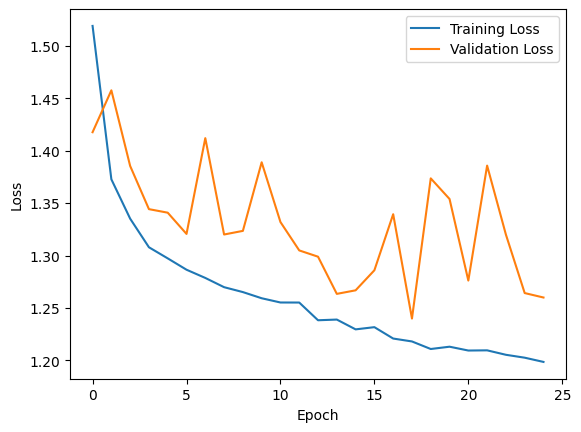

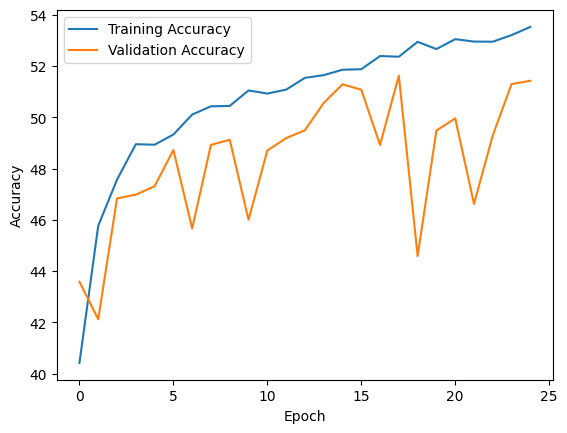

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=test_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_24780\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Test Results (Best Model):
Test Loss: 1.2499
Test Accuracy: 51.51%


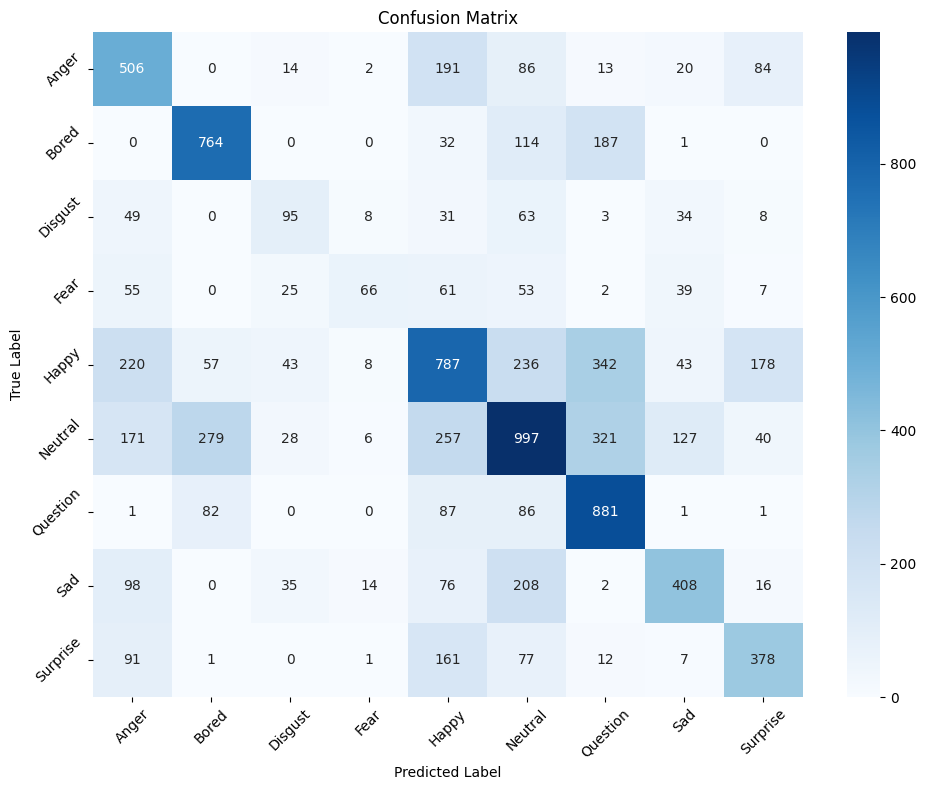

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)